In [1]:
import os
import re

import dlib
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from face_swap import warp_image_2d, warp_image_3d, mask_from_points, apply_mask, correct_colours, transformation_from_points
from TYY_model import TYY_2stream,TYY_1stream

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = "./data"

In [3]:
def open_img(name, scale=1.):
    img = cv2.imread(os.path.join(path, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)), Image.LANCZOS)
    return img

def show_img(img, figsize=(7, 14)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

In [4]:
def crop_face(img, bboxs, offset=10):
    imgs = []
    for bbox in bboxs:
        x = bbox[0] 
        y = bbox[1]
        w = bbox[2] - x
        h = bbox[3] - y

        x = max(x - offset//2, 0)
        y = max(y - offset//2, 0)
        w = min(img.shape[0], w + offset)
        h = min(img.shape[1], h + offset)
        imgs.append(img[y:y+h, x:x+w])
    return imgs

def face_detection(img):
    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    detector = dlib.get_frontal_face_detector()
    faces = detector(img, 0)
    bboxs = []

    for face in faces:
        bboxs.append((face.left(), face.top(), face.right(), face.bottom()))
    
    return bboxs

def face_points_detection(img, bbox):
    # Get the landmarks/parts for the face in box d.
    shape = predictor(img, bbox)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    coords = [(shape.part(i).x, shape.part(i).y) for i in range(68)]

    # return the list of (x, y)-coordinates
    return coords

def select_faces(im, points, r=10):
    im_w, im_h = im.shape[:2]
    left, top = np.min(points, 0)
    right, bottom = np.max(points, 0)
    
    x, y = max(0, left-r), max(0, top-r)
    w, h = min(right+r, im_h)-x, min(bottom+r, im_w)-y

    return points - np.asarray([[x, y]]), (x, y, w, h), im[y:y+h, x:x+w]

def preprocess_img(img, r=10):
    bboxs = face_detection(img)
    results = []
    for bbox in bboxs:
        points = face_points_detection(img, dlib.rectangle(*bbox))
        results.append(select_faces(img, points, r))
    return results

def get_age_gender(img):
    input_ = cv2.resize(img, (IMG_SIZE, IMG_SIZE), Image.LANCZOS)
    results = model.predict(np.expand_dims(input_, axis=0))
    predicted_genders = results[0]
    ages = np.arange(0, 21).reshape(21, 1)
    predicted_ages = results[1].dot(ages).flatten()
    return "F" if predicted_genders[0][0] > .6 else "M", predicted_ages[0]

def insert_face(dst_faces, src_faces, valid_idxs):
    
    n = np.random.choice(valid_idxs)
    dst_points, dst_shape, dst_face = dst_faces[n]
    src_points, src_shape, src_face = src_faces[0]
    
    warp_2d = True
    correct_color = True
    max_points = 68
    
    w, h = dst_face.shape[:2]

    ### Warp Image
    if not warp_2d:
        ## 3d warp
        warped_src_face = warp_image_3d(src_face, src_points[:max_points], dst_points[:max_points], (w, h))
    else:
        ## 2d warp
        src_mask = mask_from_points(src_face.shape[:2], src_points, radius=2)
        src_face = apply_mask(src_face, src_mask)
        # Correct Color for 2d warp
        if correct_color:
            warped_dst_img = warp_image_3d(dst_face, dst_points[:max_points], 
                                           src_points[:max_points], src_face.shape[:2])
            src_face = correct_colours(warped_dst_img, src_face, src_points)
        # Warp
        warped_src_face = warp_image_2d(src_face, transformation_from_points(dst_points, src_points), (w, h, 3))

    ## Mask for blending
    mask = mask_from_points((w, h), dst_points, radius=2)
    mask_src = np.mean(warped_src_face, axis=2) > 0
    mask = np.asarray(mask*mask_src, dtype=np.uint8)

    ## Correct color
    if not warp_2d and correct_color:
        warped_src_face = apply_mask(warped_src_face, mask)
        dst_face_masked = apply_mask(dst_face, mask)
        warped_src_face = correct_colours(dst_face_masked, warped_src_face, dst_points)

    ##Poisson Blending
    r = cv2.boundingRect(mask)
    center = ((r[0] + int(r[2] / 2), r[1] + int(r[3] / 2)))
    output = cv2.seamlessClone(warped_src_face, dst_face, mask, center, cv2.NORMAL_CLONE)

    x, y, w, h = dst_shape
    dst_img_cp = crowd.copy()
    dst_img_cp[y:y+h, x:x+w] = output
    new_output = output.copy()
    output = dst_img_cp

    output_labeled = output.copy()
    cv2.rectangle(output_labeled, (x, y), (x+w, y+h), (255,0,0), 2)
    
    return output, output_labeled

def run_detector():
    while True:
        try:
            output, output_labeled = insert_face(DST_FACES, SRC_FACES, VALID_IDXS)
            break
        except:
            output, output_labeled = run_detector()
    return output, output_labeled

In [5]:
PREDICTOR_PATH = 'models/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(PREDICTOR_PATH)

IMG_SIZE = 64
model = TYY_1stream(IMG_SIZE)()
model.load_weights(os.path.join("models", "TYY_1stream.h5"))

In [6]:
%%time

me = open_img("you_main.jpg", scale=0.15)
crowd = open_img("playboy.png")

CPU times: user 184 ms, sys: 48 ms, total: 232 ms
Wall time: 176 ms


In [7]:
me.shape

(489, 367, 3)

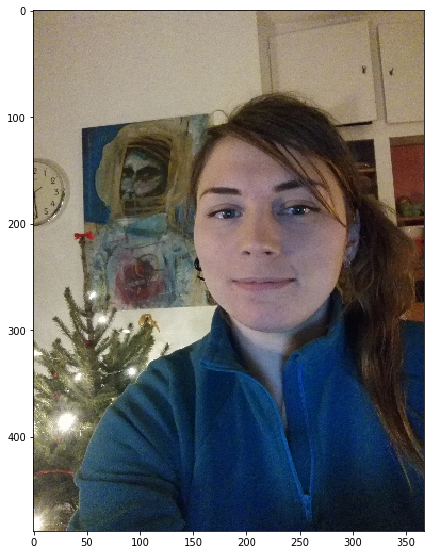

In [9]:
show_img(me)

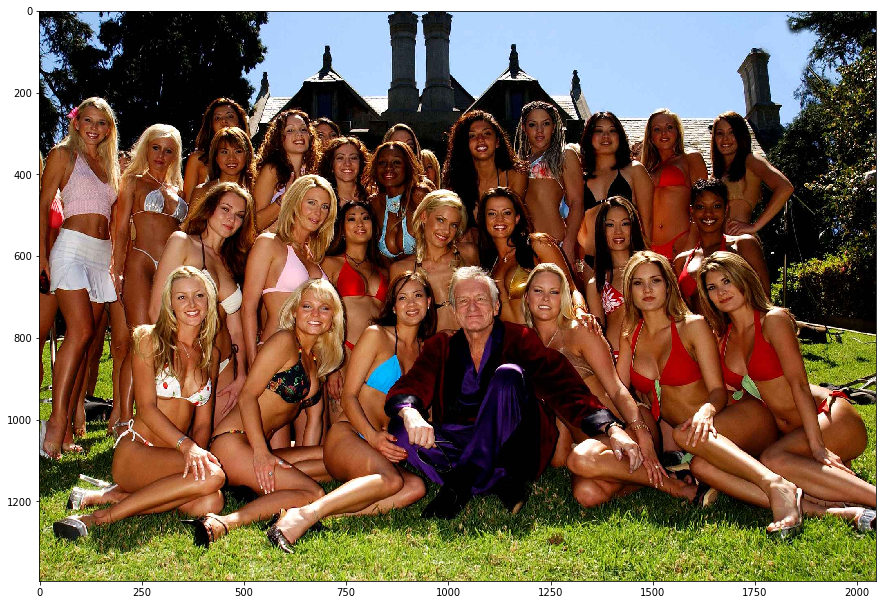

In [23]:
show_img(crowd, figsize=(15, 25))

In [8]:
%%time

DST_FACES = preprocess_img(crowd, r=10)
SRC_FACES = preprocess_img(me, r=10)

CPU times: user 896 ms, sys: 0 ns, total: 896 ms
Wall time: 892 ms


python main.py --src imgs/test6.jpg --dst imgs/test7.jpg --out results/output6_7_2d.jpg --correct_color --warp_2d

In [9]:
%%time

bboxs = face_detection(crowd)
crops = crop_face(crowd, bboxs, offset=10)

bboxs = face_detection(me)
src_crop = crop_face(me, bboxs, offset=10)[0]
src_gender, src_age = get_age_gender(src_crop)
VALID_IDXS = []

if True:
    for i, crop in enumerate(crops):
        gender, age = get_age_gender(crop)
        if gender == src_gender and ((src_age - 2) <= age <= (src_age + 2)):
            VALID_IDXS.append(i)
            
if len(VALID_IDXS) == 0:
    VALID_IDXS = list(range(len(crops)))

CPU times: user 1.31 s, sys: 152 ms, total: 1.46 s
Wall time: 1.42 s


In [12]:
output, output_labeled = run_detector()

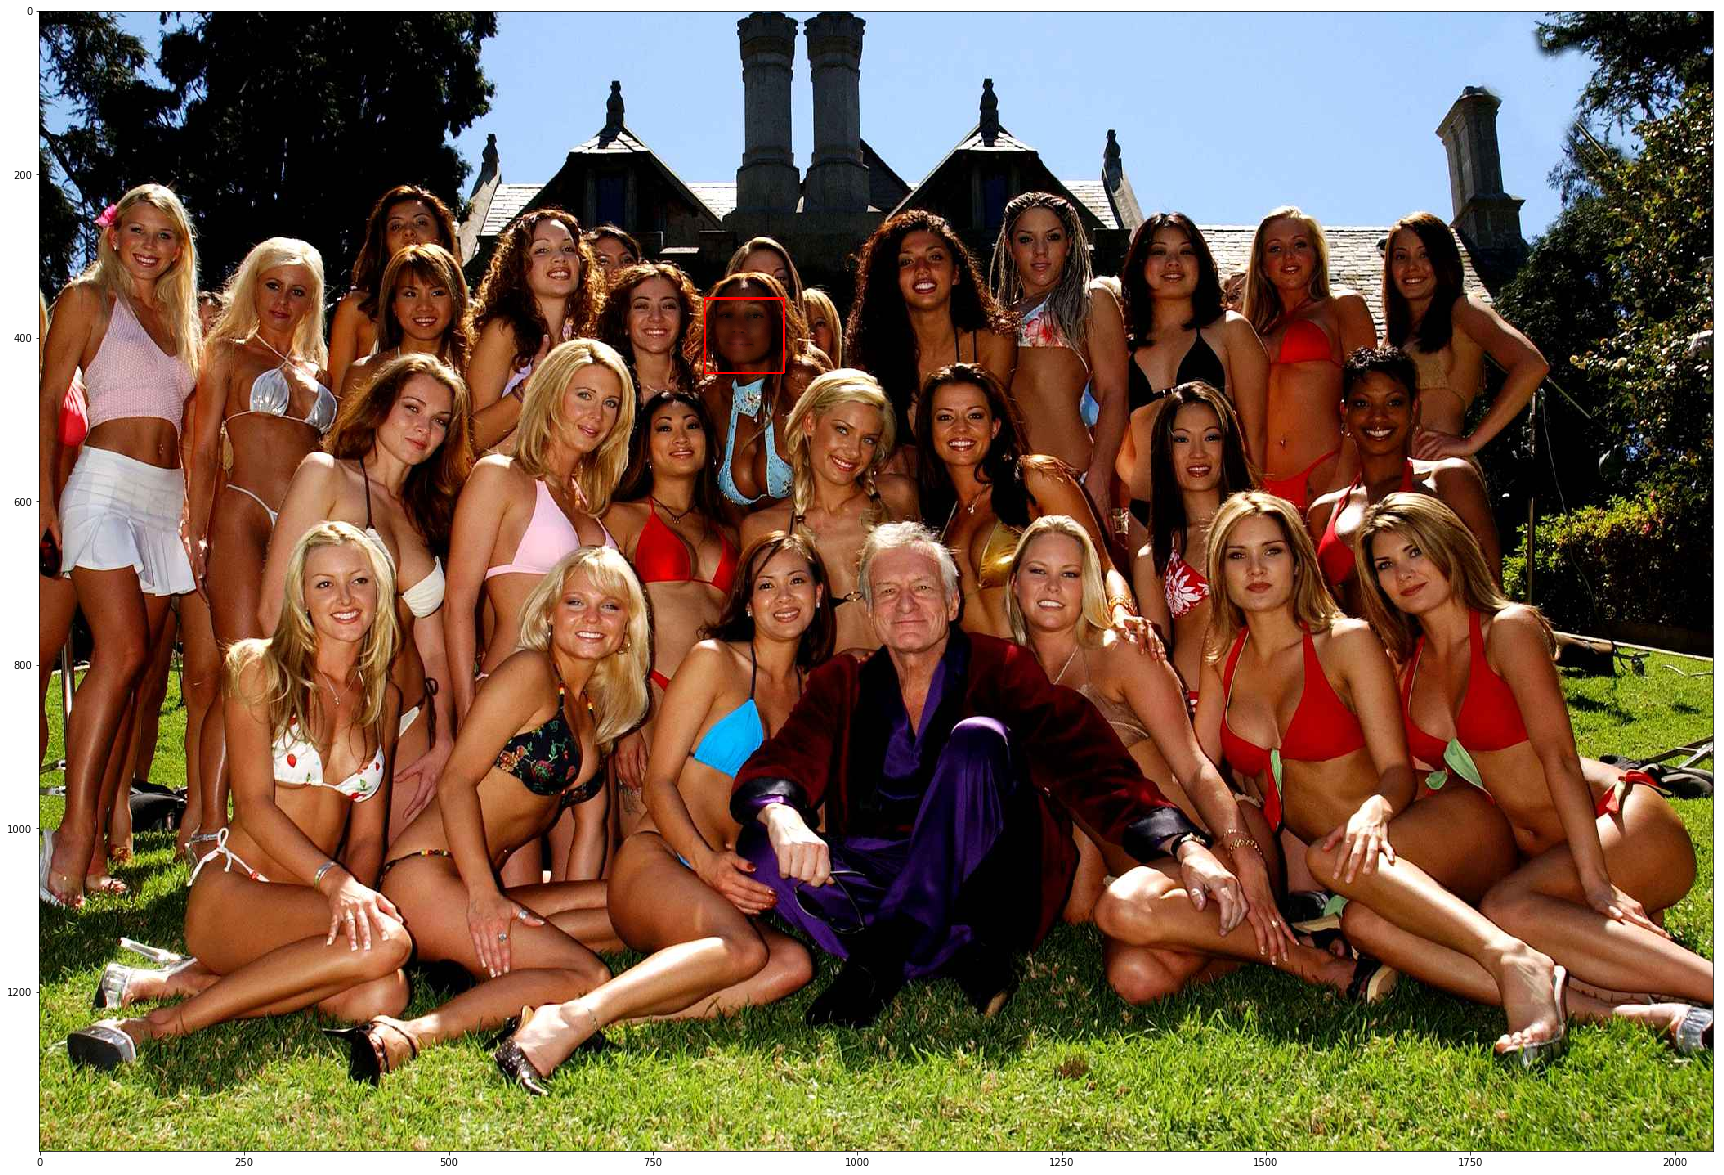

In [13]:
show_img(output_labeled, figsize=(30, 60))

In [15]:
plt.imshow(dst_face)

NameError: name 'dst_face' is not defined

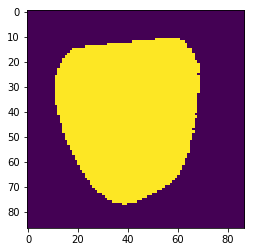

In [75]:
plt.imshow(mask)

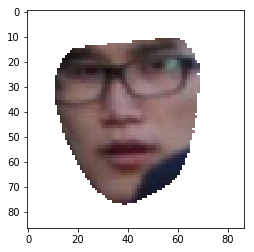

In [76]:
plt.imshow(np.concatenate([dst_face, mask[:, :, np.newaxis]], axis=2))

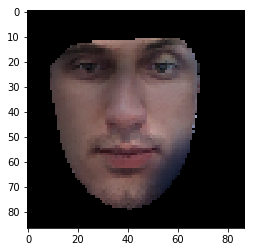

In [77]:
plt.imshow(warped_src_face)

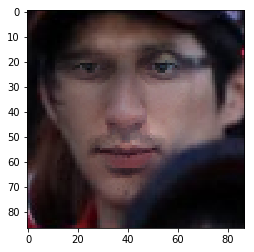

In [78]:
plt.imshow(new_output)

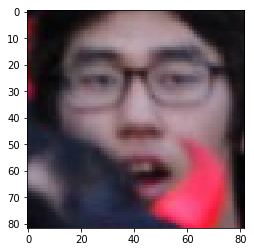

In [173]:
n = 7

plt.imshow(crops[n])
plt.show()

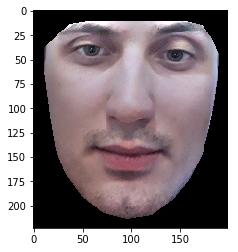

In [23]:
plt.imshow(src_face)

In [35]:
points = face_detection(me)[0]
me_cropped = me[points[1]:points[3], points[0]:points[2]]

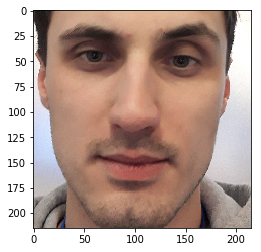

In [79]:
plt.imshow(me_cropped)
plt.show()

In [37]:
cv2.imwrite("./data/me_cropped.jpg", me_cropped)

True

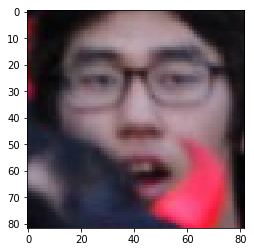

In [173]:
n = 7

plt.imshow(crops[n])
plt.show()